## Notebook for India region plots

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import mapping, Point
import datetime
import numpy as np
import rioxarray
from scipy.interpolate import griddata

import xarray as xr

## Administrative boundaries data
The data are taken from [GADM](https://gadm.org/about.html), version 4.1. Data are distributed in GeoPackage format. Two different files are used:
- **WORLD**: contains the first level (countries) for the entire world (*data/gadm_410-levels.gpkg*)
- **INDIA**: contains the four administration levels of India (*data/gadm41_IND.gpkg*)



#### *Administrative division of India*
- Level 0: Country
- Level 1: States and union territories
- Level 2: District
- Level 3: Taluc

<sub><sup> *DISCLAIMER: Some regions in this area are disputed between states. The authors do not take responsibility for the borders shown, which are sourced from the GADM dataset.* </sup></sub>

In [2]:
world = gpd.read_file('data/gadm_410-levels.gpkg')

india_states = gpd.read_file('data/gadm41_IND.gpkg', layer='ADM_ADM_1')
india_districts = gpd.read_file('data/gadm41_IND.gpkg', layer='ADM_ADM_2')
india_talucs = gpd.read_file('data/gadm41_IND.gpkg', layer='ADM_ADM_3')

/home/jgrassi/miniconda3/lib/python3.11/site-packages/pyogrio/geopandas.py:261: UserWarning: More than one layer found in 'gadm_410-levels.gpkg': 'ADM_0' (default), 'ADM_1', 'ADM_2', 'ADM_3', 'ADM_4', 'ADM_5'. Specify layer parameter to avoid this warning.
  result = read_func(


In [34]:
def get_ordinal_suffix(day):
    if 10 <= day <= 20:
        return 'th'
    else:
        last_digit = day % 10
        if last_digit == 1:
            return 'st'
        elif last_digit == 2:
            return 'nd'
        elif last_digit == 3:
            return 'rd'
        else:
            return 'th'
        
def day_of_year_to_date(day_of_year, year=None):
    if year is None:
        year = datetime.datetime.now().year
    
    try:
        date = datetime.datetime(year, 1, 1) + datetime.timedelta(days=day_of_year - 1)
        day = date.day
        month = date.strftime("%b")
        ordinal_suffix = get_ordinal_suffix(day)
        return fr"{month} {day}{ordinal_suffix}"
    except ValueError:
        return "Invalid day of the year"

def plot_map(geo_df=None, column_to_color=None, cmap=None, vmin=None, vmax=None, title=None):
    """
    Plots a geographical map with optional coloring based on a specified column.

    Parameters:
    geo_df (GeoDataFrame): The geographical data to plot.
    column_to_color (str): The column name in geo_df used for coloring the map.
    cmap (str or colormap): The colormap used for plotting.
    vmin (float): The minimum value for colormap scaling.
    vmax (float): The maximum value for colormap scaling.
    title (str): The title of the plot.

    Returns:
    ax (Axes): The axes of the plot.
    fig (Figure): The figure of the plot.
    cbar (Colorbar): The colorbar of the plot.
    """

    # Define the figure and axes
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # Plot the geographical data if provided
    if geo_df is not None:
        cax = geo_df.plot(column=column_to_color, cmap=cmap, ax=ax, legend=False, vmin=vmin, vmax=vmax)
    else:
        india_states.plot(color='b', alpha=0.3, ax=ax)

    # Plot boundaries for districts and states within India
    #india_districts.boundary.plot(color='white', linewidth=0.2, ax=ax)
    india_states.boundary.plot(color='k', linewidth=0.3, ax=ax)

    # List of neighboring countries to include in the map
    states = ['CHN', 'AFG', 'PAK', 'NPL', 'LKA', 'MMR', 'TJK', 'BTN', 'BGD', 'THA']
    
    # Plot boundaries for each neighboring country
    for state in states:
        world[world.GID_0 == state].boundary.plot(color='k', linewidth=0.3, ax=ax)
        world[world.GID_0 == state].plot(color='gray', alpha=0.3, ax=ax)

    # Customize the plot axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Longitude [°E]')
    ax.set_ylabel('Latitude [°N]')
    ax.grid(alpha=0.5)

    # Initialize colorbar
    cbar = None

    # Create and add a custom colorbar if a colormap is provided
    if cmap is not None:
        cmap = plt.get_cmap(cmap, 5)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', drawedges=True)

        vecs = np.linspace(geo_df[column_to_color].min(),geo_df[column_to_color].max(),6)
        cbar.set_ticks(ticks=vecs, labels=[day_of_year_to_date(x) for x in vecs])
        cbar.set_label('Date')
        cbar.outline.set_visible(False)
        cbar.dividers.set_color('white')
        cbar.dividers.set_linewidth(1.5)

    # Set the title of the plot if provided
    if title is not None:
        ax.set_title(title)

    # Set the limits for the plot
    ax.set_xlim(65, 99)
    ax.set_ylim(6, 36)

    return ax, fig, cbar

# plot_map(title='Basemap')

In [28]:
dates_tab = pd.read_excel('data/dates.xlsx')
dates_tab = dates_tab[['lat','lon','ons_num','wit_num']]

def agg_date(dates_tab, geodataframe):

    # Step 2: Convert the points dataframe to a GeoDataFrame
    geometry = [Point(xy) for xy in zip(dates_tab['lon'], dates_tab['lat'])]
    points_gdf = gpd.GeoDataFrame(dates_tab, geometry=geometry)

    # Ensure both GeoDataFrames use the same coordinate reference system (CRS)
    points_gdf.crs = geodataframe.crs

    # Step 3: Perform a spatial join
    joined = gpd.sjoin(points_gdf, geodataframe, how="inner", predicate='within')

    # # Step 4: Calculate the averages
    average_values = joined.groupby('index_right')[['ons_num', 'wit_num']].mean()

    # # Join the average values back to the original geodataframe
    final_geodataframe = geodataframe.join(average_values, how='left')

    final_geodataframe['ons_num'] = final_geodataframe['ons_num'].interpolate(method='cubic')
    final_geodataframe['wit_num'] = final_geodataframe['wit_num'].interpolate(method='cubic')
    final_geodataframe['len'] = final_geodataframe['wit_num'] - final_geodataframe['ons_num']

    return final_geodataframe


states_dates = agg_date(dates_tab, india_states)
districts_dates = agg_date(dates_tab, india_districts)

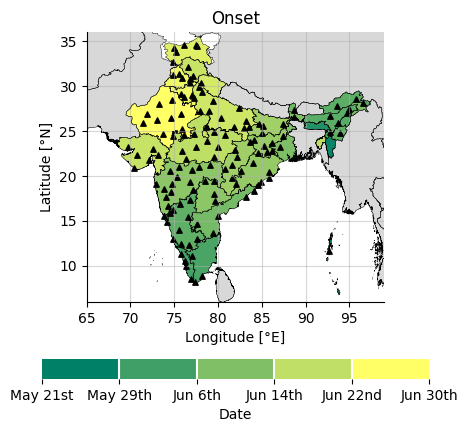

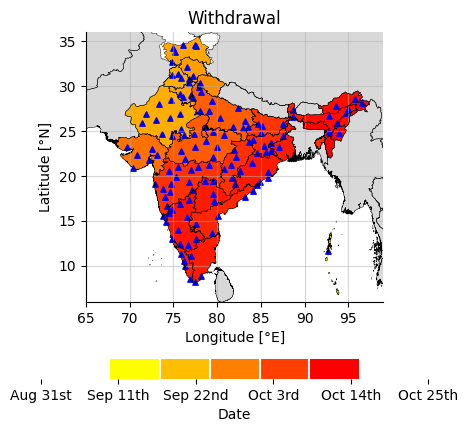

In [36]:
ax, fig, cbar = plot_map(states_dates, 'ons_num', 'summer', states_dates['ons_num'].min(), states_dates['ons_num'].max(), 'Onset')
ax.scatter(dates_tab['lon'],dates_tab['lat'], s=15, c='k', marker="^")

ax, fig, cbar = plot_map(states_dates, 'wit_num', 'autumn_r', states_dates['wit_num'].min(), states_dates['wit_num'].max(), 'Withdrawal')
ax.scatter(dates_tab['lon'],dates_tab['lat'], s=15, c='b', marker="^") 

# ax, fig, cbar = plot_map(states_dates, 'len', 'Blues', states_dates['len'].min()+5, states_dates['len'].max()-5, 'Length')
# ax.scatter(dates_tab['lon'],dates_tab['lat'], s=15, c='r', marker="^") 
# cbar.set_label('# Days')
# cbar.outline.set_visible(False)

## Gridding the data

In [37]:
lon = dates_tab.lon.to_numpy()
lat = dates_tab.lat.to_numpy()


onset = dates_tab.ons_num.to_numpy()
withdrawal = dates_tab.wit_num.to_numpy()

points = list(zip(lon, lat))
lon_fin = np.arange(np.min(lon),np.max(lon),0.25)
lat_fin = np.arange(np.min(lat),np.max(lat),0.25)

gridX, gridY = np.meshgrid(lon_fin, lat_fin)

regrid_ons = griddata(points, onset, (gridX, gridY ), method='cubic')
regrid_wit = griddata(points, withdrawal, (gridX, gridY ), method='cubic')

In [38]:
ds = xr.Dataset(
    data_vars=dict(
        onset=(["lat", "lon"], regrid_ons),
        withdrawal=(["lat", "lon"], regrid_wit),
    ),
    coords=dict(
        lon=lon_fin,
        lat=lat_fin,
    ),
    attrs=dict(description="Weather related data."),
)

In [39]:
ds.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
ds.rio.write_crs("epsg:4326", inplace=True)
ds_rast = ds.rio.clip(india_states.geometry.apply(mapping), india_states.crs, drop=True)

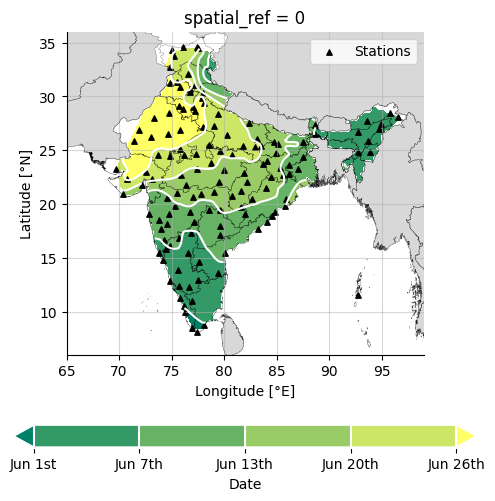

In [19]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

lev = np.linspace(ds_rast.onset.min()+11,ds_rast.onset.max()-10,5)

cont_1 = ds_rast.onset.plot.contourf(levels=lev, extend='both',ax=ax, add_colorbar=False, cmap='summer')


# Plot boundaries for districts and states within India
#india_districts.boundary.plot(color='white', linewidth=0.2, ax=ax, alpha=0.5)
india_states.boundary.plot(color='k', linewidth=0.3, ax=ax, alpha=0.5)

# List of neighboring countries to include in the map
states = ['CHN', 'AFG', 'PAK', 'NPL', 'LKA', 'MMR', 'TJK', 'BTN', 'BGD', 'THA']

# Plot boundaries for each neighboring country
for state in states:
    world[world.GID_0 == state].boundary.plot(color='k', linewidth=0.3, ax=ax, alpha=0.5)
    world[world.GID_0 == state].plot(color='gray', alpha=0.3, ax=ax)

contours_0 = ds_rast.onset.plot.contour(levels=lev ,ax=ax, colors='white',linewidths=1.5)
#ax.clabel(contours_0, inline=True, fontsize=7)

# Set the limits for the plot
ax.set_xlim(65, 99)
ax.set_ylim(6, 36)

# Customize the plot axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Longitude [°E]')
ax.set_ylabel('Latitude [°N]')
ax.grid(alpha=0.5)

ax.scatter(dates_tab['lon'],dates_tab['lat'], s=15, c='k', marker="^", label='Stations')
ax.legend(loc='upper right')

cbar = plt.colorbar(cont_1, orientation='horizontal', drawedges=True)
cbar.set_ticks(ticks=lev, labels=[day_of_year_to_date(x) for x in lev])

cbar.outline.set_color('white')
cbar.outline.set_linewidth(2)
cbar.dividers.set_color('white')
cbar.dividers.set_linewidth(1.5)

cbar.set_label('Date')